## Imports

In [1]:
import torch as tr
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np
from models import Actor, Critic, Memory
from plotting import plot_epoch, plot_simulation_data
from enviroment import Box2DEnv
# from enviroment_utils import Box
from gym import spaces

import time


device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
tr.autograd.set_detect_anomaly(True)
tr.set_default_tensor_type(tr.FloatTensor)

## Settings

In [2]:
# ---------------- Training -------------------
runs = 1
max_episodes = 40
max_steps = 200
# batch_size = 16
target_model_update = max_episodes//10
gamma_discount = 0.8
learning_rate = 0.001
learning_rate_decay = 0.8
memory_size = 50
memory_batch_size = 10
entropy_temperature = 0.01

# ---------------- Environment  ----------------
# Time step size
dt = 0.0375

# Target
goal_width = 0.2
goal_height = 0.2
goal_center = np.tile([0.5,0],(memory_batch_size,1))

# Spacial Constraints
space_width = 1.5
space_height = 1.5
space_center = np.tile([0,0],(memory_batch_size,1))

#noise
characteristic_length = 1

# Maximum of potential
U0 = 0.4

# ---------------- Agent ----------------------
# Actor
actor_mlp_dims = [5, 32, 32]
actor_activation = nn.ReLU()

#Critic
critic_mlp_dims = [6, 32, 32]
critic_activation = nn.ReLU()

# ---------------- Other ----------------------
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'figure.dpi': 150})
total_time = []
update_state_time = []

## Episode

In [3]:
def train_episode(actor,critic,target_actor,target_critic, enviroment, optimizer):
    mse_loss = nn.MSELoss()
    
    #Initialize Replay Buffer
    memory = Memory(memory_size)
    states = [enviroment.state]
    actions = []
    total_losses = np.array([])

    
    # Perform Episode
    for i in range(max_steps): 
        time_start = time.time()
        optimizer.zero_grad()
        if i%target_model_update == 0:
            target_actor.load_state_dict(actor.state_dict())
            target_critic.load_state_dict(critic.state_dict())

        #Execute action
        state_now = tr.tensor(enviroment.state,dtype = tr.float).to(device)
        theta_now, _ = actor.forward(state_now)
        action = theta_now.detach().cpu().numpy()
        enviroment.step(action, U0, dt)
        new_state = tr.tensor(enviroment.state).to(device)
        
        #Calculate Reward and store transition
        Q_now = critic(state_now, theta_now)
        memory.push(state_now, theta_now, new_state, Q_now)

        #Memory Sampling
        state_batch, action_batch, reward_batch, next_state_batch = memory.sample(memory_batch_size)

        prediction = critic(state_batch, action_batch)
        theta_future, log_prob = target_actor(next_state_batch)
        Q_future = target_critic(next_state_batch, theta_future) 
        target = reward_batch + gamma_discount *(Q_future - entropy_temperature*log_prob)
        loss = mse_loss(target, prediction)

        #Compute Gradients
        time_state_start = time.time()
        
        total_losses = np.append(total_losses,loss.item())
        # kl_losses = np.append(kl_losses,KL.item())
        # mse_losses = np.append(mse_losses,mse_loss.item())
        actions.append(theta_now)
        loss.backward()
        optimizer.step()


        #Detach Variables
        state = state.detach()
        Reward = Reward.detach()

        #Store Episode Data
        states.append(state)

        update_state_time.append(time.time()-time_state_start)

        
        if enviroment.goal_check.max().item() > 0: 
            # success_batch_index = tr.argmax(target_bool.int()).item()
            break
            # print('Goal Reached!')
        total_time.append(time.time()-time_start)
        

    if success_batch_index is None: success_batch_index = 0
    states = tr.stack(states)
    total_losses =  total_losses.mean()
    actions = tr.stack(actions)
    return states, success_batch_index, actions, total_losses


## Simulation

In [4]:
def train_simulation():
    #Initalize Enviroment
    space_box = spaces.Box(low=-space_width/2, high=space_width/2, shape=(2,), dtype=np.float64)
    goal_box = spaces.Box(low=np.array([0.4,-0.1]), high=np.array([0.6,0.1]), dtype=np.float64)
    enviroment = Box2DEnv(space_box, goal_box)

    #Initialize Agent-Critic Networks
    actor = Actor(actor_mlp_dims, actor_activation).to(device)
    target_actor = Actor(actor_mlp_dims, actor_activation,).to(device)

    critic = Critic(critic_mlp_dims, critic_activation).to(device)
    target_critic = Critic(critic_mlp_dims, critic_activation).to(device)

    
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    #Optimizer
    params = list(actor.parameters()) + list(critic.parameters())
    optimizer = tr.optim.Adam(params, lr=learning_rate)

    #Store Paths
    x_paths, y_paths = [], []
    total_mean_losses = []

    #Perform a Run
    for i in range(max_episodes):
        enviroment.reset()
        
        states, success_batch_index, actions, losses = train_episode(actor, critic, target_actor, target_critic, enviroment, optimizer)
        # sucess_batch_indexes.append(success_batch_index)
        total_mean_losses.append(losses)

        print(f'Episode {i+1}: Mean = {np.round(tr.mean(actions).item(),2)}, std = {np.round(tr.std(actions).item(),2)}')

        if i%(max_episodes//5) == max_episodes//5-1:
            x_path = states[:,:, 0]
            y_path = states[:,:, 1]
            x = x_path[:,success_batch_index].detach().to('cpu').numpy()
            y = y_path[:,success_batch_index].detach().to('cpu').numpy()
            x_paths.append(x)
            y_paths.append(y)
            # scheduler.step()

    return actor,x_paths, y_paths, total_mean_losses


In [5]:
actor, x_paths, y_paths, total_mean_losses = train_simulation()
print(f'Total Step Time: {np.round(np.mean(total_time), 5)}, Update State Time: {np.round(np.mean(update_state_time),5)}, Ratio: {np.round(np.mean(update_state_time)/np.mean(total_time),5)}')

AttributeError: 'list' object has no attribute 'type'

## Plotting

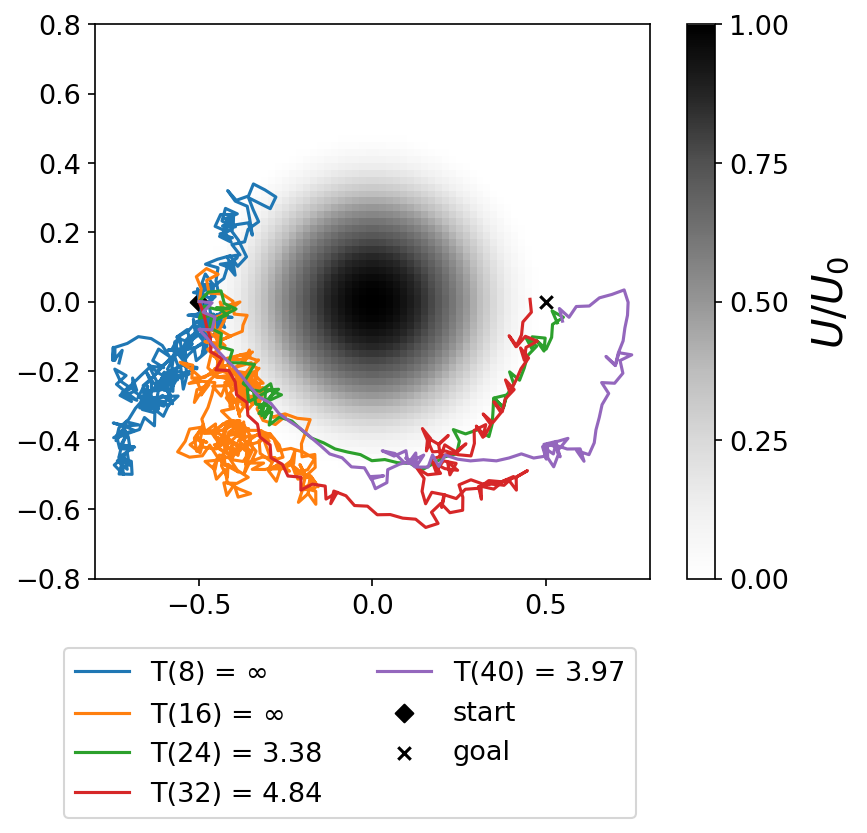

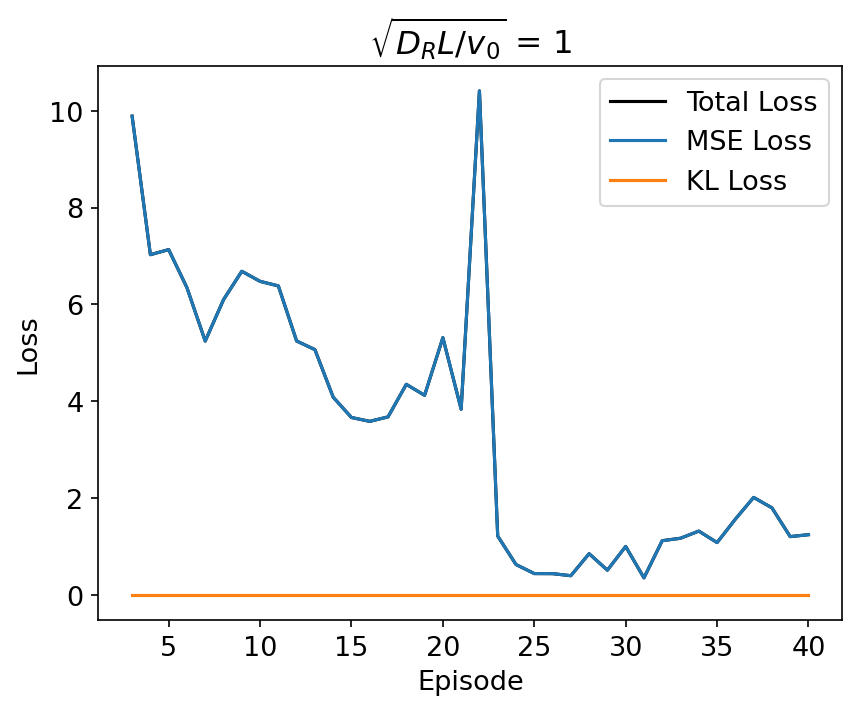

In [ ]:
plot_epoch(x_paths, y_paths, max_steps, max_episodes, dt, U0)
# plot_simulation_data(total_mean_losses,  max_episodes, characteristic_length)